# HEART RATE ESTIMATION

Seismocardiography([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure Heart Rate (HR) and Respiratory Rate (RR) with the detector positioned above sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with combination of both accelerometer and gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., accelerometer platform mounted under the slats of the bed).   
  
MuSe(Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provide by [221e](https://www.221e.com). In the context of this project, It allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform. 
The study must be performed on two datasets: the first is the compulsory one (**center_sternum.txt**) while the second is left at the discretion of the group, among those made available for the assignment.

**N.B: Remember that normal beat is around [40-100] bpm.**


## Dataset

The data is provided in .txt file. During this study two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* **center_sternum.txt**: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

1. **1_Stave_supine_static.txt**: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* **2_Mattress_supine.txt**: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* **3_Subject_sitting_chair.txt**: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* **4_Chest_sweater.txt**: Sensor placed on the subject chest directly on a sweater. 
* **5_Under_chair.txt**: Subject sitting on a chair, sensor placed under the seat of the chair. 

All .txt files give 16 columns index, in particular: 

* Log Freq stands for the acquisition  in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(**README1.txt** for the first measurement, and in **README_5.txt** for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt file and select only the columns you are interesting in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data in function of time and choose a properly time window over which to perform the analysis. Pay attention on time rappresentation and the measurament unit.
    
    1.3. In order to make an appropiate work, decide if take care about some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use this step in order to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate heart rate signal. Hint:
    
    (a) Directly from Fourier Analysis, antitrasform data looking for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
    
    (c) Wavelet trasform (a powerfull instrument that make a time and frequency analysis of signal).
    
    (d) Find another method by yourselves.
    
    Motivate your choice.
    
    
4. Metrics:

    4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 
    
    4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.



5. (OPTIONAL) Algorithm: Elaborate a simple algorithm to extrapolate heart beat even when filter failed (e.g. look at particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, in particular making a comparison between the two files analysed. Highlight limitation and critical issues encountered during the work, motivating the most relevant contribution given by your solution.




**N.B: Indicate the contribution, to achieving the result, of each member of the group.**


# HEART RATE ESTIMATION PROJECT

In [1]:
# Load the required packages
import pandas as pd
import numpy as np
import scipy.linalg as la
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display

## Data Preparation
#### Understanding and selection of the data

First of all, we need to understand the data we are working with and prepare it for our
task. The aim of this project is to compare and analyze Heart Rate of healthy subjects measured with
two different devices. Therefore, we look at the available data and select the adeccuate
variables to study heart rate and we prepare them for our study.

In [2]:
# Load the datafile
datafile = pd.read_csv('center_sternum.txt',sep='\t')

# Look what our data is like in order to select useful columns
print("The variables in our datafile are:", datafile.columns)
print("The size of our datafile is", datafile.shape)

The variables in our datafile are: Index(['Log Mode', 'Log Freq', 'Timestamp', 'AccX', 'AccY', 'AccZ', 'GyroX',
       'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ', 'qw', 'qi', 'qj', 'qk'],
      dtype='object')
The size of our datafile is (16506, 16)


In [3]:
# Drop not needed columns
df = datafile.drop(['qw', 'qi', 'qj', 'qk'], axis = 1)

# Calibrate the data considering the used device
# First device cal data

gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_calibration = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_calibration = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])
'''
#Second device cal data
gyro_offset = np.array([-2.804399,1.793105,0.3411708])

acc_calibration = np.array([[1.002982,9.415505E-05,0.004346743],
                    [9.04459E-05, 1.002731,-0.001444198],
                    [0.004346536,-0.001444751,1.030587]])
acc_offset = np.array([3.602701,-20.96658,54.97186])

magn_calibration = np.array([[1.013437,-0.04728858,-0.001861475],
                   [-0.04728862,1.004832,0.008222118],
                   [-0.001861605,0.008221965,0.9439077]])
magn_offset = np.array([-150.4098,74.62431,630.9805])
'''
# Calibration
df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_offset.T
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']],acc_calibration.T) + acc_offset.T
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']],magn_calibration.T) + magn_offset.T

#Add time column by taking time steps of 1/logFreq
df['Time'] = np.arange(0, len(df['Log Freq']))/df['Log Freq'][0]
display(df)

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,Time
0,5,200,1576222772,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690,0.000
1,5,200,1576222772,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890,0.005
2,5,200,1576222772,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890,0.010
3,5,200,1576222772,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605,0.015
4,5,200,1576222772,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605,0.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16501,5,200,1576222847,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764,82.505
16502,5,200,1576222847,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222,82.510
16503,5,200,1576222847,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222,82.515
16504,5,200,1576222847,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388,82.520


#### Plotting the data and choosing a time frame

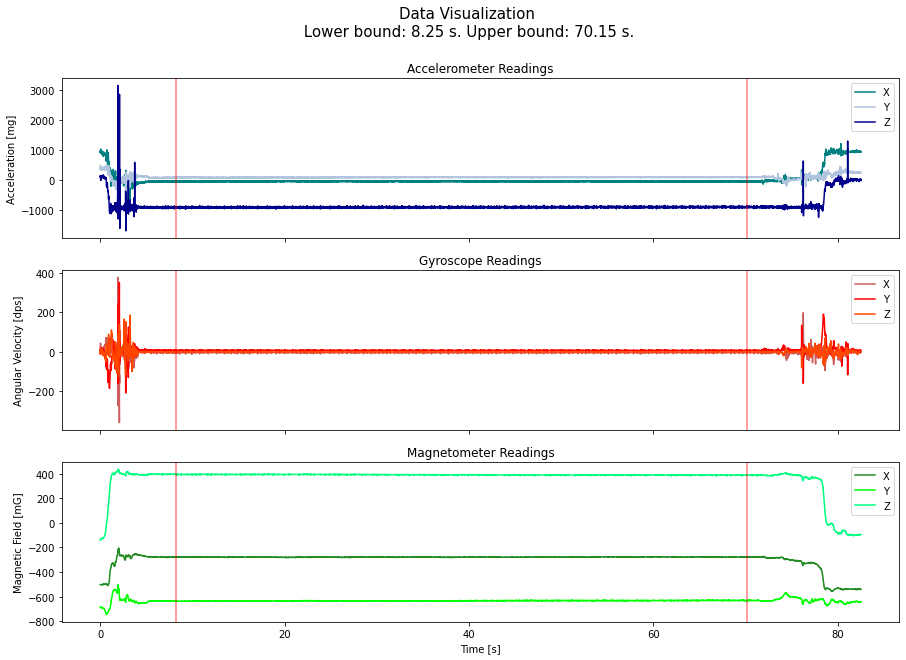

In [4]:
# Look at the data and trim 10% on the lower end and 15% on the upper one (limits have been chosen according to the plots)

lowlimit = df['Time'][int(0.1*len(df['Time']))]
highlimit = df['Time'][int(0.85*len(df['Time']))]

(fig, axs) = plt.subplots(3,1,figsize=(15,10), sharex=True)

fig.suptitle(f'Data Visualization\n Lower bound: {lowlimit} s. Upper bound: {highlimit} s.', fontsize = 15)

axs[0].set_title('Accelerometer Readings')
axs[0].plot(df['Time'], df['AccX'], color= 'teal',label='X')
axs[0].plot(df['Time'], df['AccY'], color= 'lightsteelblue',label='Y')
axs[0].plot(df['Time'], df['AccZ'], color= 'darkblue',label='Z')
axs[0].axvline(x = lowlimit, color = 'red', alpha = 0.5)
axs[0].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[0].set_ylabel('Acceleration [mg]')
axs[0].legend()

axs[1].plot(df['Time'], df['GyroX'],color = 'indianred', label='X')
axs[1].plot(df['Time'], df['GyroY'],color = 'red' , label='Y')
axs[1].plot(df['Time'], df['GyroZ'],color = 'orangered' , label='Z')
axs[1].set_title('Gyroscope Readings')
axs[1].axvline(x = lowlimit, color = 'red', alpha = 0.5)
axs[1].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[1].set_ylabel('Angular Velocity [dps]')
axs[1].legend()

axs[2].plot(df['Time'], df['MagnX'],color = 'forestgreen' , label='X')
axs[2].plot(df['Time'], df['MagnY'], color = 'lime', label='Y')
axs[2].plot(df['Time'], df['MagnZ'], color = 'springgreen', label='Z')
axs[2].set_title('Magnetometer Readings')
axs[2].axvline(x = lowlimit, color = 'red', alpha = 0.5)
axs[2].axvline(x = highlimit, color = 'red', alpha = 0.5)
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Magnetic Field [mG]')
axs[2].legend()
plt.show()

#### Limit time between thresholds

In [5]:
# Cut the misleading rows by trimming the data based on time
df_timecut = df.loc[(df['Time'] >= lowlimit) & (df['Time'] <= highlimit)] #limit analysis to the specified time frame

# Select the columns we need for the PCA, drop the unimportant ones
df_time_frame = df_timecut.drop(['Log Mode', 'Log Freq', 'Timestamp', 'Time'], axis=1)
display(df_time_frame)

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1650,-37.476891,102.563273,-907.655555,-4.501766,6.215371,-1.573359,-278.899995,-637.942189,393.901226
1651,-39.855996,103.053747,-912.431818,-5.539934,6.810791,-1.405420,-278.943017,-636.108179,394.784542
1652,-36.491725,105.399753,-929.035450,-6.043751,7.345143,-1.313817,-278.943017,-636.108179,394.784542
1653,-47.111798,92.350697,-890.606398,-6.089552,7.314608,-0.672595,-278.966269,-635.193303,394.788799
1654,-35.935845,96.230388,-906.972954,-6.196423,7.375677,-0.458855,-278.966269,-635.193303,394.788799
...,...,...,...,...,...,...,...,...,...
14026,-46.603314,113.623834,-904.236820,-9.524667,4.902394,-2.199313,-277.221820,-632.524980,388.684933
14027,-39.727249,109.294866,-855.912008,-11.112453,5.528349,-2.168779,-276.279283,-633.463108,388.684157
14028,-46.933633,107.748107,-848.555029,-9.371995,6.612318,-2.107710,-276.279283,-633.463108,388.684157
14029,-53.106252,109.190281,-845.306946,-6.410163,7.818425,-1.390153,-277.198568,-633.439856,388.680676


#### STATISTICAL QUANTITIES

Find statistical quantities and use them to center our data in order to perform a PCA.

In [6]:
statistics = pd.DataFrame({
    'mean'  : df_time_frame.mean(),
    'median': df_time_frame.median(),
    'variance': df_time_frame.var(),
    'standard deviation': df_time_frame.std(),
    '25% percentile' : df_time_frame.quantile(q=0.25),
    '75% percentile': df_time_frame.quantile(q=0.75)}).T

print('Statistics of the data set')
display(statistics)

# Center the data
centered_df = (df_time_frame - statistics.iloc[0])

# Normalize the data
standardized_df = centered_df/statistics.iloc[3]

print('Standardized Data')
display(standardized_df)

Statistics of the data set


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
mean,-34.313318,100.845493,-892.569491,-4.331309,6.645650,-1.584158,-278.656348,-633.691478,391.146106
median,-34.259900,100.989385,-892.968158,-4.394896,6.597051,-1.573359,-278.962788,-633.412347,391.285341
variance,49.486769,27.420896,212.043834,2.060900,0.524829,0.134298,1.448028,3.114447,6.658165
standard deviation,7.034683,5.236497,14.561725,1.435583,0.724451,0.366467,1.203340,1.764780,2.580342
25% percentile,-38.949126,97.422824,-901.281989,-4.929247,6.230639,-1.817634,-279.090603,-635.178566,388.689191
75% percentile,-29.616485,104.316631,-884.678736,-3.723140,6.963463,-1.344351,-278.046984,-632.474220,393.906260


Standardized Data


,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
1650,-0.449711,0.328040,-1.036008,-0.118737,-0.593938,0.029470,-0.202476,-2.408635,1.067734
1651,-0.787907,0.421705,-1.364009,-0.841905,0.227953,0.487734,-0.238228,-1.369407,1.410059
1652,-0.309667,0.869715,-2.504233,-1.192854,0.965549,0.737696,-0.238228,-1.369407,1.410059
1653,-1.819340,-1.622229,0.134812,-1.224758,0.923399,2.487433,-0.257551,-0.850999,1.411709
1654,-0.230647,-0.881334,-0.989132,-1.299203,1.007696,3.070678,-0.257551,-0.850999,1.411709
...,...,...,...,...,...,...,...,...,...
14026,-1.747058,2.440246,-0.801233,-3.617594,-2.406313,-1.678607,1.192122,0.660988,-0.953817
14027,-0.769605,1.613555,2.517386,-4.723615,-1.542273,-1.595287,1.975389,0.129404,-0.954118
14028,-1.794013,1.318174,3.022613,-3.511246,-0.046010,-1.428644,1.975389,0.129404,-0.954118
14029,-2.671468,1.593582,3.245669,-1.448090,1.618846,0.529394,1.211444,0.142580,-0.955467


## PCA

As we have a large amount of data, we perform a Principal Component Analysis to
get the lowest dimension dataset possible without missing important information. We start by studying the covariance
matrix of the data.

In [7]:
# Covariance matrix of the data
cov = np.cov(standardized_df.T) 
print('Covariance matrix is: \n')
print(cov)

# Eigenvalues and eigenvectors of covariance matrix
l, V = la.eig(cov)
print('\n')

# Study most important variances in the dataset
var = []
for i in range(len(l)):
    var.append(np.real_if_close(l[i]/l.sum()))
for i in range(len(var)):
    print('The direction described by the eigenvector', V[:,i], 'with eigenvalue', np.round(np.real_if_close(l[i]),5), 'accounts for', np.round(var[i]*100,5), '% of the dataset variance.')

Covariance matrix is: 

[[ 1.         -0.18010652 -0.40684445  0.2071927   0.00827065  0.02497423
  -0.38367823 -0.02537724  0.0747912 ]
 [-0.18010652  1.          0.16840543 -0.05379475 -0.00833644 -0.14244271
   0.24035145  0.35395883 -0.48795478]
 [-0.40684445  0.16840543  1.         -0.08043832  0.11577611  0.01927046
   0.11970488  0.19965284 -0.24294729]
 [ 0.2071927  -0.05379475 -0.08043832  1.          0.40355401  0.3901244
  -0.06008825 -0.05702054  0.02488998]
 [ 0.00827065 -0.00833644  0.11577611  0.40355401  1.          0.43688409
   0.01007242 -0.13008042  0.02667903]
 [ 0.02497423 -0.14244271  0.01927046  0.3901244   0.43688409  1.
  -0.0152078  -0.07247408  0.01869308]
 [-0.38367823  0.24035145  0.11970488 -0.06008825  0.01007242 -0.0152078
   1.          0.2212077  -0.31159662]
 [-0.02537724  0.35395883  0.19965284 -0.05702054 -0.13008042 -0.07247408
   0.2212077   1.         -0.74322389]
 [ 0.0747912  -0.48795478 -0.24294729  0.02488998  0.02667903  0.01869308
  -0.311

Now we rotate the data in the new base, thus taking a linear combination of physical quantities.

In [8]:
# Order eigenvalues and eigenvectors according to variance importance
idx = np.argsort(l)[::-1]  # sort the eigenvalues and eigenvectors
l_sort = l[idx]
V_sort = V[idx]
tr = l.sum()

# Rotate the dataset to the base of eigenvalues and eigenvectors
rotated_data = np.dot(V.T, standardized_df.T) #bring the dataset in the eigenvector basis

# Create a dataframe with the Principal Components of the dataset
PC_names = []
for i in range(1,len(l_sort)+1): PC_names.append(f"PC{i}")
    
dataset_rotated = pd.DataFrame(rotated_data.T, columns = PC_names)

# Store the weights value of each PC in a dictionary
weights = dict()
i = 0
for PC in PC_names:
    weights[PC] = np.real_if_close(l_sort[i]/tr)
    i += 1

# Find out how many columns of the PCA we can drop while keeping 80% of the info
S, j = 0, 0
while S < 0.8:
    S += weights[PC_names[j]]
    j += 1
info_PC = S
n_PC = j
print("Reduction of the number of PC and its accuracy:")
print(np.round(info_PC*100, 2), '%, number of PC = ', n_PC)
print(weights)

Reduction of the number of PC and its accuracy:
80.89 %, number of PC =  5
{'PC1': array(0.27805573), 'PC2': array(0.19878023), 'PC3': array(0.15245001), 'PC4': array(0.09816959), 'PC5': array(0.08146999), 'PC6': array(0.06315282), 'PC7': array(0.05846528), 'PC8': array(0.04405207), 'PC9': array(0.02540427)}


In [9]:
# With the results, we can lower the number of variables to n_PC
dataset_rotated = dataset_rotated.drop(PC_names[n_PC:], axis = 1)
display(dataset_rotated)

,PC1,PC2,PC3,PC4,PC5
0,-1.685239,0.955760,1.013715,-0.754276,-1.014271
1,-1.388061,0.618198,1.065919,0.213701,-0.998374
2,-1.731896,0.392483,0.408007,0.336534,-1.678237
3,-1.609219,-0.829762,2.686721,0.332564,0.210873
4,-2.156733,-1.019641,1.144500,0.551991,-0.466820
...,...,...,...,...,...
12376,3.684263,3.776254,0.555251,-0.038279,-1.247281
12377,4.137528,3.313988,2.113312,-0.145135,0.623236
12378,4.016005,1.650090,2.997731,-0.180835,0.827152
12379,3.300205,-1.466948,3.348192,-0.103097,1.227406


## FREQUENCY ANALYSIS

Once we have our data prepared for working, we start by studying its frequency.
This gives us an idea of the frequency domain of the Heart Beat.

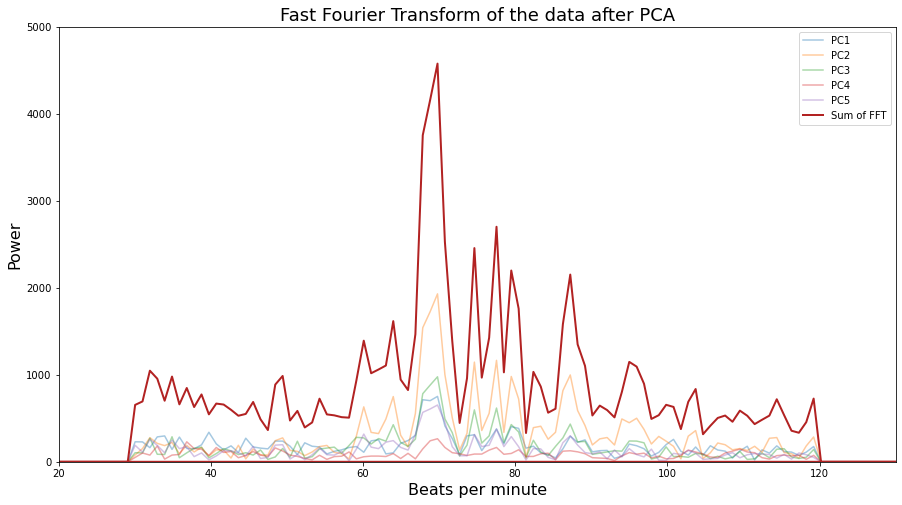

Highest peak is at: 69.78 beats per minute


In [10]:
sample_freq = 200

# FFT
FFTs = {} # create a dictionary to store the FFT of each PC
for i in dataset_rotated:
    FFTs[i] = np.abs(np.fft.fft(dataset_rotated[i]))

freq_FFT = np.fft.fftfreq(d = 1/sample_freq, n = len(dataset_rotated['PC1']))

# Set frequency limits
min_f = 30/60  #minimum for athletes is 30 beats per minute
max_f = 120/60 #maximum (sustainable) is around 120 beats per minimum
for i in FFTs:
    FFTs[i][freq_FFT <= min_f] = 0
    FFTs[i][freq_FFT >= max_f] = 0

# As each PC gives the frequencies of the heartbeat, we can sum all of them (weighted) to get a better idea of the
# heart rate of the subject
total_FFT = np.zeros(len(FFTs['PC1']))
for i in FFTs:
    total_FFT += FFTs[i]

# Plot the frequencies
frequencies_fig = plt.figure(figsize=(15, 8))
for i in FFTs:
    plt.plot(freq_FFT*60, FFTs[i], label=i, alpha = 0.4)
plt.plot(freq_FFT*60, total_FFT, label='Sum of FFT', color = 'firebrick', linewidth = 2)
plt.xlim([min_f*60-10, max_f*60+10])
plt.ylim([0, 5000])
plt.xlabel('Beats per minute', fontsize = 16)
plt.ylabel('Power', fontsize = 16)
plt.title('Fast Fourier Transform of the data after PCA', fontsize = 18)
plt.legend()
plt.show()

# Find the value of the highest peak
idx_max = np.argmax(total_FFT)
peak_freq = freq_FFT[idx_max]*60
print("Highest peak is at:", np.round(peak_freq,2), "beats per minute")

## FILTER

As we can see from observing the data in the frequency domain, the subject heart rate ranges from 60 to 100.
The goal now is to filter the data to get a clearer view of these heart rate values, and
to analyze them with respect to time. To do so we have implemented a butterworth bandpass filter, followed by a wavelet.

#### Butterworth bandpass filter

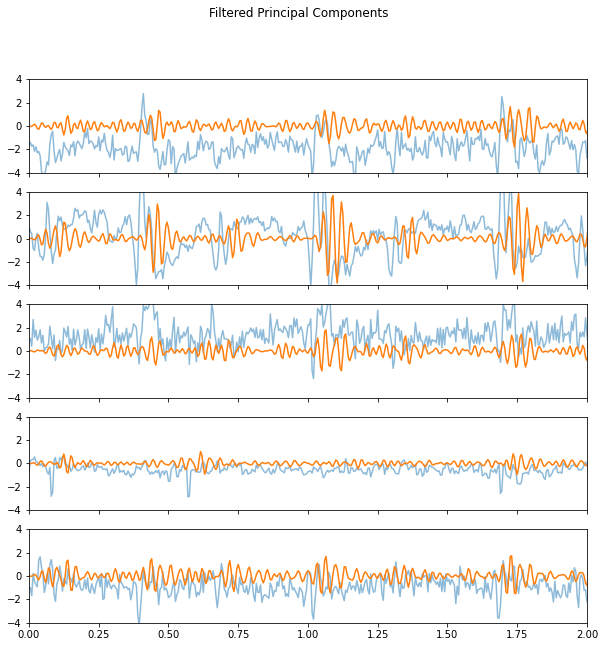

In [11]:
# Add a time column to the dataframe
dataset_rotated['Time'] = np.arange(0, len(dataset_rotated['PC1']))/sample_freq

# butterworth bandpass filter
sos = signal.butter(4, [50,90], 'bp', fs = 400, output = 'sos')

filtered_PCs = {}
for i in FFTs:
    filtered_PCs[i] = signal.sosfilt(sos, dataset_rotated[i])

fig, axs = plt.subplots(n_PC,1, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Filtered Principal Components')
ax = 0
for i in filtered_PCs:
    axs[ax].plot(dataset_rotated['Time'], dataset_rotated[i], alpha = 0.5)
    axs[ax].plot(dataset_rotated['Time'], filtered_PCs[i])
    axs[ax].set_xlim([0,2])
    axs[ax].set_ylim([-4,4])
    ax += 1

#### Wavelet transform

In [12]:
import pywt
import copy

In [13]:
def wavelet_transform(signal, levels, waveletType, showWaveletScales):
    # first do the transform using the input signal with the wavelet type and levels inputed
    transformCoeffs = pywt.wavedec(signal, waveletType, level=levels)
    
    # Create a time array and a result array
    time = np.array(dataset_rotated['Time'])
    result = np.zeros((levels+1, len(time)+1))
    
    # Loop for every level 
    for i in range(levels+1):
        coeffs = copy.deepcopy(transformCoeffs)
        
        for j in range(levels+1):
            # Loop over every other level and set to zero
            if(i!=j):
                coeffs[j] = np.zeros_like(coeffs[j])
        
        #add the inverse wavelet of the level i to the corresponding result row
        result[i] = pywt.waverec(coeffs, waveletType)
        
    # Option to visualize the wavelet scale decomposition
    if showWaveletScales == True:
        for level in range(levels+1):
            # Plot each level
            plt.figure(figsize=(15, 5))
            plt.plot(time, result[level][:-1])
            plt.title(f'Wavelet Transform of PC1 for level {level}')
            plt.xlabel('Time')
            plt.show()
        
    return transformCoeffs    
    '''Do transform, loop over every level and set all other levels to zero and add to the final 
        coefficients array, removing noise from other leverls. Then loop through each level again 
        and plot the inverse wavelet.
    '''

In [14]:
def waveletFilter(coeffs, indices, waveletType):
    for level in range(len(coeffs)):
        if level in indices:
            coeffs[level] = np.zeros_like(coeffs[level])
    return pywt.waverec(coeffs, waveletType)

In [15]:
# Pipeline Filter function
def filterSignal(sig):

    # Passes a signal through a bandpass and wavelet filter and returns the filtered signal
    bandpass = signal.sosfilt(sos, sig)
    wavelet = wavelet_transform(np.array(bandpass), 5, 'sym4', False)
    wavelet_filtered = waveletFilter(wavelet, [0,1,2,4,5], 'sym4')
        # 0,1,2,5,6
    #0, 1, 3, 4
    return wavelet_filtered[:-1]
    #return bandpass

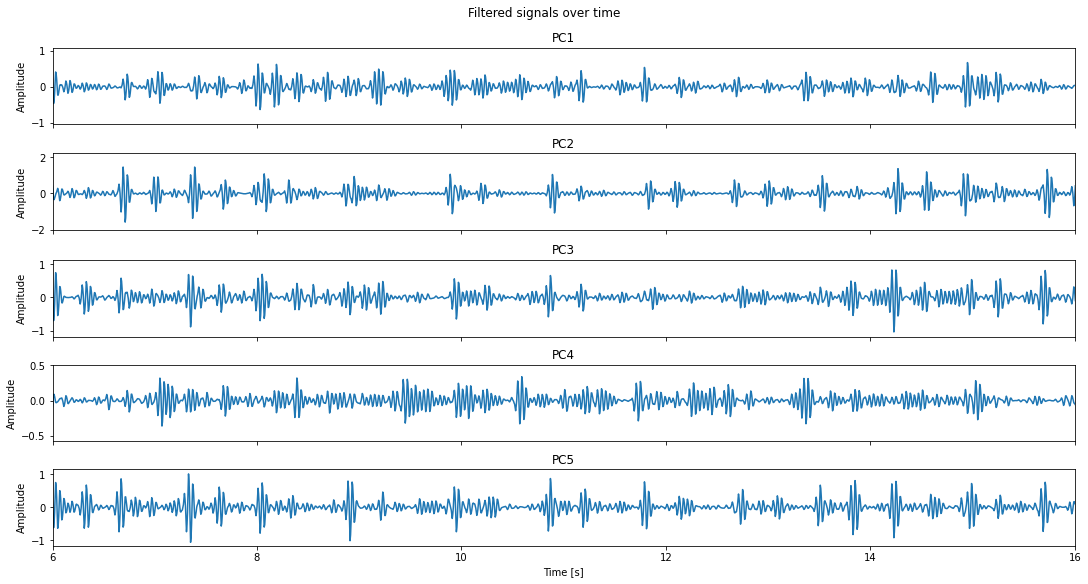

In [16]:
# Apply the filters to the data
PCs = dict()
for i in FFTs:
    # Assign the filtered signal to each principal component
    PCs[i] = filterSignal(dataset_rotated[i])

(fig, axs) = plt.subplots(n_PC,1,figsize = (15,8), sharex=True, constrained_layout=True)
fig.suptitle('Filtered signals over time')
plt.xlabel('Time [s]')
plt.xlim(6, 16)
ax = 0
for i in PCs:
    axs[ax].plot(np.array(dataset_rotated['Time']), (PCs[i]), label=i)
    axs[ax].set_title(f'{i}')
    axs[ax].set_ylabel('Amplitude')
    ax += 1
plt.show()

## Motivate your choice.



# METRICS

## 4.1. Heart Beat Per Minute(BPM): extrapolate BPM, make an histogram of the result. Does it follow a partiular distribution? 

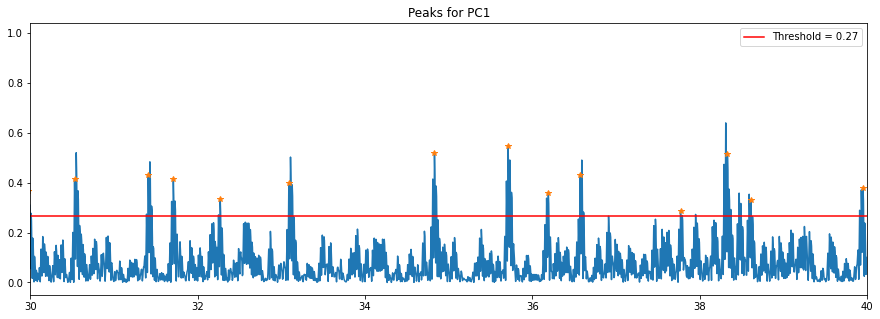

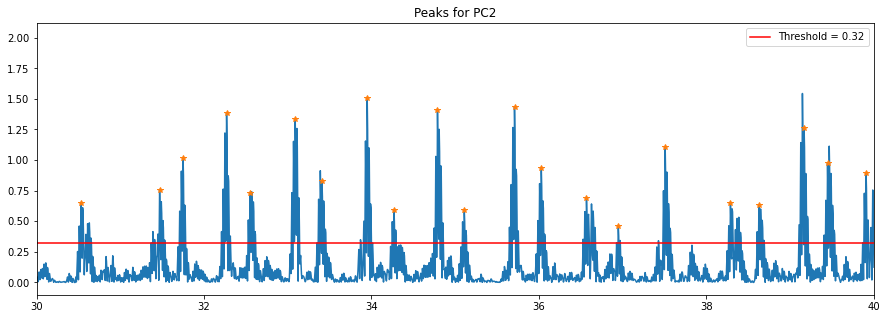

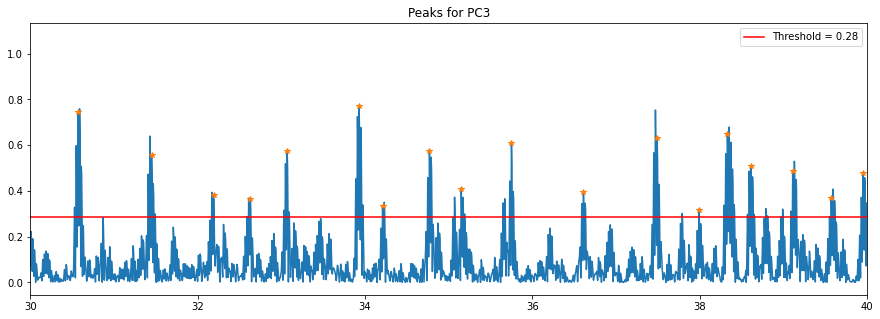

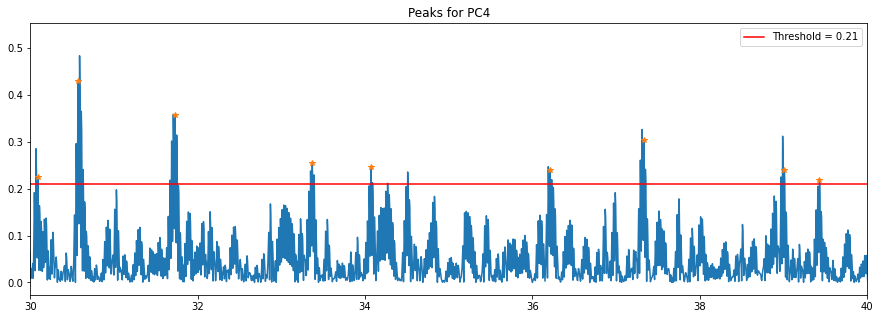

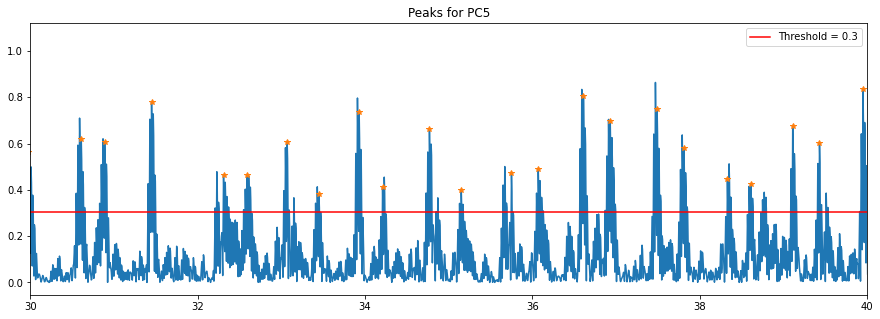

In [48]:
# Find the peaks in the filtered data
# scipy function find_peaks finds indexes of the peaks when provided:
# height: minimum height of a measured peak
# distance: minimum number of indexes between measured peaks

# Function for, given the peak indexes, finding corresponding time and height
def peak_points(indices, time, signl):
    x_peaks = []
    y_peaks = []
    for i in indices:
        x_peaks.append(time[i])
        y_peaks.append(signl[i])
    return np.array(x_peaks), np.array(y_peaks)

PC_times = dict()

for i in PCs:
    lorenzetti = np.sum(np.abs(PCs[i])**(1/2))/(len(PCs[i]))
    
    # Find peaks of the signal and their times
    peaks = signal.find_peaks((PCs[i]), height =lorenzetti, distance = 40)
    time_PC, peaks_PC = peak_points(peaks[0], np.array(dataset_rotated['Time']), PCs[i])
    
    #Store the times of the peaks
    PC_times[i] = time_PC
    
    #Plot peaks
    plt.figure(figsize=(15,5))
    plt.plot(np.array(dataset_rotated['Time']), np.abs(PCs[i]))
    plt.plot(time_PC, (peaks_PC), '*')
    plt.axhline(lorenzetti,color='red', label = f'Threshold = {np.round(lorenzetti,2)}')
    plt.legend()
    plt.title(f'Peaks for {i}')
    plt.xlim([30,40])
    plt.show()

In [18]:
# We should filter the points that are valuable and estimate the periodicity between peaks
# we said highest possible frequency = 120bpm, therefore it is only reasonable
# that there is a peak at least every 1/120*60 seconds = 0.5s

# This function makes sure of the above
def time_frame(t, a, b):
    # break if it is out of bounds of time
    if b > (len(t)-1): return 0, 0
    measure = (t[b] - t[a])
    if measure > 0.5:
        return measure, b
    else:
        b += 1
        return time_frame(t, a, b)

    
def heartbeat(times):
    # Takes in times of the peaks, and returns the heartbeat values and 
    # times of the heartbeats
    
    periodicity = []
    time_beat = []
    b = 0
    for i in range(len(times)):
        if i == b:
            p, b = time_frame(times, i, (i+1))
            periodicity.append(p)
            time_beat.append((times[b]+times[i])/2)
    periodicity.pop()
    time_beat.pop()
    HB_values = 1/np.array(periodicity)*60

    return HB_values, time_beat

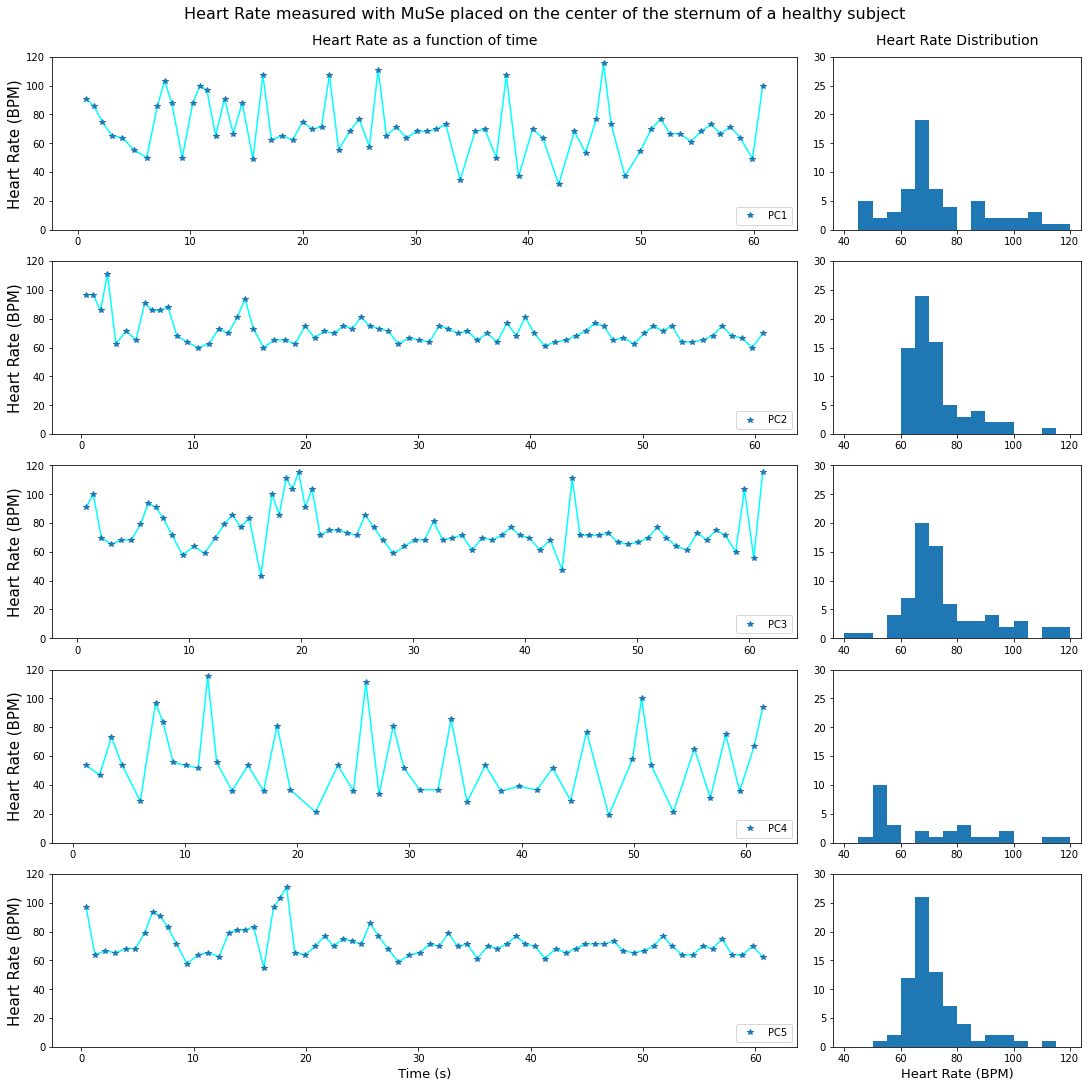

72


In [31]:
counts = np.zeros(16)

fig, axs = plt.subplots(n_PC, 2, figsize = (15, 15), gridspec_kw={'width_ratios': [3, 1]}, constrained_layout=True)
plt.suptitle('Heart Rate measured with MuSe placed on the center of the sternum of a healthy subject', fontsize = 16)
axs[n_PC-1,0].set_xlabel('Time (s)', fontsize = 13)
axs[n_PC-1,1].set_xlabel('Heart Rate (BPM)', fontsize = 13)
axs[0,0].set_title('Heart Rate as a function of time', fontsize = 14, pad = 12)
axs[0,1].set_title('Heart Rate Distribution', fontsize = 14, pad = 12)
ax = 0
for i in PC_times:
    HB_values, time_beat = heartbeat(PC_times[i])
    #heartbeat as a function of time
    axs[ax,0].plot(time_beat, HB_values, color = 'cyan')
    axs[ax,0].plot(time_beat, HB_values, '*', label = i)
    axs[ax,0].set_ylabel('Heart Rate (BPM)', fontsize = 15)
    axs[ax,0].legend(loc = 'lower right')
    axs[ax,0].set_ylim([0,120])
    #histogram
    n, bins, patches = axs[ax,1].hist(HB_values, bins=16, range=(40, 120))
    axs[ax,1].set_ylim([0,30])
    counts += n*weights[i]/info_PC
    ax += 1

plt.show()
print(len(time_beat))

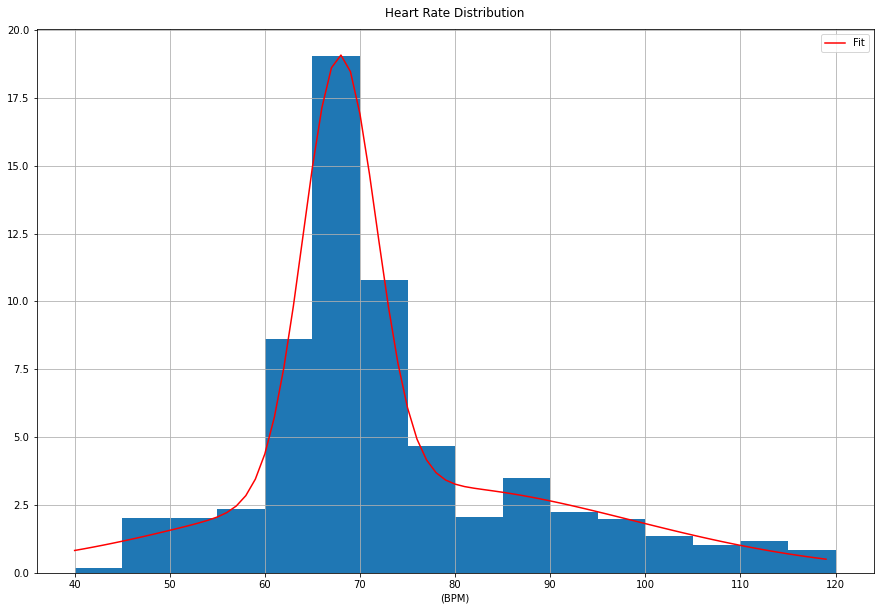

[16.11655891 67.88465686  3.83910371  3.19807165 76.43999157 22.11325901]


In [47]:
from scipy import optimize
# Fit the histogram  to a gaussian
def gauss(x, amp, mu, sigma):
    #return height + amp*np.exp(-0.5*((x - mu)/sigma)**2)
    return amp*np.exp(-0.5*((x - mu)/sigma)**2)

def bimodal(x, amp1, mu1, sigma1,amp2,mu2,sigma2):
    return gauss(x,amp1,mu1,sigma1)+gauss(x,amp2, mu2,sigma2)

X = np.arange(42.5,122.5,5)
#popt, pcov = optimize.curve_fit(gauss, X, counts, p0 = (0., 0., 69, 20))
popt, pcov = optimize.curve_fit(bimodal, X, counts, p0 = (0,69,5,0,88,5))


X_plot = np.arange(40,120,1)
# Plot
plt.figure(figsize = (15,10))
plt.plot(X_plot, bimodal(X_plot, *popt), color = 'red', label='Fit')
plt.grid(True)
plt.legend()

plt.bar(X, counts, width=5, align='center')
plt.title('Heart Rate Distribution', pad = 12)
plt.xlabel('(BPM)')
plt.show()

print(popt)

In [21]:
#empty cell, do not delete, just edit

## 4.2. Heart Rate Variability(HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

In [22]:
#empty cell, do not delete, just edit

In [23]:
#empty cell, do not delete, just edit


# CONCLUSIONS